# Calculate MassBank Metabolomics Coverage for PubChem

### Imports

In [1]:
import numpy as np
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
import requests
from xml.etree import ElementTree


from minedatabase.metabolomics import MetabolomicsDataset, Peak

### Read Credentials for MongoDB

In [2]:
with open('./../credentials.txt', 'r') as infile:
    lines = infile.readlines()
    username = lines[0].strip().split('=')[1]
    password = lines[1].strip().split('=')[1]

### Read MassBank Test Data File

In [3]:
massbank_filepath = './../Data/MassBankTestSet.csv'

mb_df = pd.read_csv(massbank_filepath, delimiter='\t', names=['Name', 'Charge', 'Mass', 'Mode', 'None', 'Adduct', 'InChI_Key'])
mb_df = mb_df.drop(['None'], axis=1)

In [4]:
mb_df.head()

,Name,Charge,Mass,Mode,Adduct,InChI_Key
0,Metamitron-desamino,0,188.0818,Positive,[M+H]+,OUSYWCQYMPDAEO-UHFFFAOYSA-N
1,4-Isopropylaniline,0,136.1121,Positive,[M+H]+,LRTFPLFDLJYEKT-UHFFFAOYSA-N
2,Metolachlor morpholinone,0,234.1489,Positive,[M+H]+,DVBDYPDVNRJKNJ-UHFFFAOYSA-N
3,"2,6-Dichlorobenzamide",0,189.9821,Positive,[M+H]+,JHSPCUHPSIUQRB-UHFFFAOYSA-N
4,Amitraz,0,294.1965,Positive,[M+H]+,QXAITBQSYVNQDR-UHFFFAOYSA-N


In [5]:
mb_df.tail()

,Name,Charge,Mass,Mode,Adduct,InChI_Key
662,Robinetin trimethyl ether,0,345.0969,Positive,[M+H]+,NJNGYVOYOVPWBB-UHFFFAOYSA-N
663,"3-Hydroxy-3',4',5'-trimethoxyflavone",0,329.1020,Positive,[M+H]+,MWFLTXAQDCOKEK-UHFFFAOYSA-N
664,Carbobenzoxy-L-asparagine,0,265.0830,Negative,[M-H]-,FUCKRCGERFLLHP-SECBINFHSA-N
665,(S)-(-)-Perillic acid,0,165.0921,Negative,[M-H]-,CDSMSBUVCWHORP-MRVPVSSYSA-N
666,Kaempferide,0,299.0561,Negative,[M-H]-,SQFSKOYWJBQGKQ-UHFFFAOYSA-N


In [6]:
mb_df = mb_df.loc[mb_df['Mass'] <= 600]

In [7]:
mb_df.tail()

,Name,Charge,Mass,Mode,Adduct,InChI_Key
662,Robinetin trimethyl ether,0,345.0969,Positive,[M+H]+,NJNGYVOYOVPWBB-UHFFFAOYSA-N
663,"3-Hydroxy-3',4',5'-trimethoxyflavone",0,329.1020,Positive,[M+H]+,MWFLTXAQDCOKEK-UHFFFAOYSA-N
664,Carbobenzoxy-L-asparagine,0,265.0830,Negative,[M-H]-,FUCKRCGERFLLHP-SECBINFHSA-N
665,(S)-(-)-Perillic acid,0,165.0921,Negative,[M-H]-,CDSMSBUVCWHORP-MRVPVSSYSA-N
666,Kaempferide,0,299.0561,Negative,[M-H]-,SQFSKOYWJBQGKQ-UHFFFAOYSA-N


In [8]:
len(mb_df)

634

### Search PubChem for Masses in Sauer Test Data File

In [35]:
def ms_adduct_search(peak, ms_params, adducts):
    ids = set()
    
    potential_masses = [(peak.mz - adduct[2]) / adduct[1] for adduct in adducts]
    
    if ms_params["ppm"]:
        precision = (ms_params["tolerance"] / 100000.0) * potential_masses
    else:
        precision = ms_params["tolerance"] * 0.001  # convert to mDa
    upper_bounds = [pm + precision for pm in potential_masses]
    lower_bounds = [pm - precision for pm in potential_masses]

    # search database for hits in the each adducts mass range that have no
    # innate charge.
    mongo_ids = []
    for i, adduct in enumerate(adducts):
        response = search_pubchem(lower_bounds[i], upper_bounds[i])
        
        tree = ElementTree.fromstring(response.content)
        
        for e in tree.find('IdList').iter('Id'):
            _id = e.text.strip()
            ids.add(_id)

    return ids

In [77]:
def search_pubchem(lower, upper):
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pccompound&retmax=100000&term={lower}:{upper}[exactmass]"
    response = requests.get(url)
    return response

In [78]:
adducts = [("[M+]+", 1, 0),
           ("[M+H]+", 1, 1.007276),
           ("[M+Na]+", 1, 22.989218)]
ms_params = {
    'adducts': ["[M+]+", "[M+H]+", "[M+Na]+"],
    'tolerance': 2,  # mDa
    'ppm': False,
    'halogens': True,
    'verbose': False,
    'charge': '+',
    'models': []
}

In [79]:
ids = mb_df.loc[mb_df.Mode == 'Positive'].index
masses = [str(val) for val in mb_df.loc[mb_df.Mode == 'Positive'].Mass.values]
len(masses)

587

In [81]:
hits_dict = {}
peaks = []
for cpd_id, mass in zip(ids, masses):
    peak = Peak(cpd_id, 0, float(mass), 0)
    hits_dict[cpd_id] = ms_adduct_search(peak, ms_params, adducts)
    peaks.append(peak)
    print(cpd_id, mass, len(hits_dict[cpd_id]))

0 188.0818 12042
1 136.1121 3426
2 234.1489 39628
3 189.9821 852
4 294.1965 9873
5 257.0478 8154
6 336.1166 13888
7 141.0771 8314
8 216.0325 3647
9 382.0816 16114
10 411.1081 17831
11 432.0642 7856
12 134.0713 3551
13 322.0777 19412
14 214.1121 18564
15 174.0541 8857
16 219.0086 2567
17 201.0692 8672
18 193.1335 17339
19 188.0697 15645
20 215.0703 11158
21 215.0849 10884
22 125.0379 1143
23 330.137 22508
24 208.0968 15135
25 226.1662 24074
26 230.1167 48433
27 202.0854 25706
28 274.1186 31358
29 302.1057 26549
30 153.1022 7989
31 230.1167 48433
32 166.1226 13344
33 241.0963 40048
34 453.1187 11982
35 482.1756 12071
36 240.115 34372
37 441.167 15351
38 515.2442 5890
39 559.2603 3325
40 304.1543 27139
41 197.084 10051
42 231.1104 28457
43 177.1386 8418
44 278.1903 8454
45 136.1121 3426
46 290.1387 35510
47 272.2009 16097
48 278.1903 8454
49 238.0993 25202
50 178.1226 16217
51 310.2165 7843
52 150.1277 4543
53 327.1371 22210
54 256.1696 27558
55 240.1594 19682
56 370.1795 22358
57 308.050

483 187.039 4099
484 273.0758 17228
485 211.1329 20990
486 411.1802 25567
487 339.1591 30875
489 233.1285 31498
490 282.17 29908
491 395.1489 23315
492 511.3394 2192
494 368.1129 16299
495 315.189 3845
496 363.134 25605
497 308.222 8813
498 269.0809 22610
499 334.1649 25315
500 233.1285 31498
501 370.1649 27807
502 384.1806 25238
503 222.1125 21615
504 428.1857 17101
505 357.2636 5844
506 430.2013 15837
507 352.118 18400
508 382.1649 23277
509 219.1128 23964
510 253.0859 21390
511 285.0758 18454
512 269.0809 22610
513 458.1962 12686
515 314.1751 35517
516 376.2483 8142
518 415.1388 16384
519 257.0809 20509
520 457.1122 10781
521 381.2036 29709
522 266.1387 39981
523 352.1616 28880
524 355.2022 31513
525 546.2698 3016
526 340.1544 31844
527 351.2067 21476
528 414.3367 981
531 323.0196 8238
532 217.0496 6729
533 431.2768 5077
536 244.0928 25793
537 372.1806 31125
538 285.0394 8492
539 239.0703 13960
541 176.103 13000
542 213.1023 14792
543 255.0652 14000
545 156.0768 11415
549 184.0968 1

In [82]:
adducts = [("[M-]-", 1, -1.007276),
           ("[M+CH3COO]-", 1, 59.013851)]
ms_params = {
    'adducts': ["[M-]-", "[M+CH3COO]-"],
    'tolerance': 2,  # mDa
    'ppm': False,
    'halogens': True,
    'verbose': False,
    'charge': '-',
    'models': []
}

In [83]:
ids = mb_df.loc[mb_df.Mode == 'Negative'].index
masses = [str(val) for val in mb_df.loc[mb_df.Mode == 'Negative'].Mass.values]
len(masses)

47

In [84]:
for cpd_id, mass in zip(ids, masses):
    peak = Peak(cpd_id, 0, float(mass), 0)
    hits_dict[cpd_id] = ms_adduct_search(peak, ms_params, adducts)
    peaks.append(peak)
    print(cpd_id, mass, len(hits_dict[cpd_id]))

110 450.0204 2056
115 145.06186 1617
117 203.0826 13444
118 118.05096 865
123 132.03023 621
130 300.2908 1720
136 450.05678 5365
388 406.2024 9456
394 141.0193 889
419 343.0823 7055
420 301.2173 7012
427 367.1187 11795
432 251.0713 7938
439 339.1714 44870
440 301.1445 13895
441 301.2173 7012
458 345.1343 17911
459 263.1289 25280
467 325.0929 14608
471 435.1296 9150
472 423.1296 10166
473 455.353 2866
479 289.0717 5730
488 309.098 15620
493 179.035 1853
514 471.348 3074
530 547.2661 3715
534 193.0354 2310
535 391.2854 4514
540 241.083 10467
544 173.0455 3531
546 285.098 15083
547 301.0717 6485
548 375.2904 2699
552 579.1719 2656
554 277.2173 7162
558 178.0509 3812
559 465.3216 2950
570 123.0451 1410
574 205.0362 2580
588 381.182 32547
593 304.9778 2164
644 225.0768 10082
645 383.0136 3669
664 265.083 15386
665 165.0921 9889
666 299.0561 6118


### Calculate Statistics from Search Output

In [85]:
n_annotated = 0
num_hits = []

for peak in peaks:
    hits = hits_dict[peak.name]
    if len(hits) > 0:
        n_annotated += 1
    num_hits.append(len(hits))
    print(peak.name, len(hits))

0 12042
1 3426
2 39628
3 852
4 9873
5 8154
6 13888
7 8314
8 3647
9 16114
10 17831
11 7856
12 3551
13 19412
14 18564
15 8857
16 2567
17 8672
18 17339
19 15645
20 11158
21 10884
22 1143
23 22508
24 15135
25 24074
26 48433
27 25706
28 31358
29 26549
30 7989
31 48433
32 13344
33 40048
34 11982
35 12071
36 34372
37 15351
38 5890
39 3325
40 27139
41 10051
42 28457
43 8418
44 8454
45 3426
46 35510
47 16097
48 8454
49 25202
50 16217
51 7843
52 4543
53 22210
54 27558
55 19682
56 22358
57 15037
58 1420
59 4704
60 7686
61 20086
62 19429
64 21417
65 12476
66 6132
67 14512
68 23126
69 16265
70 40936
71 9125
72 3031
73 18396
74 27176
76 37258
77 14627
78 10578
79 2886
80 4522
81 5308
82 24996
83 17554
84 19225
85 31936
86 30933
87 25805
88 23295
89 18080
90 4051
91 21455
93 35326
95 3153
96 6702
97 15976
98 12598
99 12955
100 17080
102 3561
103 21600
104 8125
105 9274
106 5331
107 28778
108 5331
109 19760
111 10974
112 9125
113 6056
114 25178
116 1692
119 7367
122 1914
124 19760
125 557
126 29042
12

In [86]:
n_annotated

634

In [87]:
n_annotated / 634

1.0

Could be lower now because we aren't using all rules?

In [90]:
np.median(num_hits)

15274.0

In [91]:
np.mean(num_hits)

16713.257097791797

Text(0, 0.5, '# Peaks')

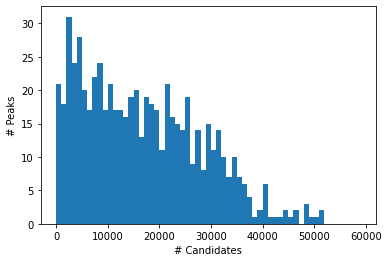

In [95]:
plt.hist(num_hits, bins=range(0, 60000, 1000))

plt.xlabel('# Candidates')
plt.ylabel('# Peaks')

In [42]:
print('Searching PubChem for specific compounds...')
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound"
matches = 0
total_cpds = 0
starting_comps = 0
mine_inchi_keys = set()
inchi_key_string = ''
for inchi_key in mb_df['InChI_Key']:
    mine_inchi_keys.add(inchi_key.split('-')[0])
    inchi_key_string = f'{inchi_key_string},{inchi_key.split("-")[0]}'
    total_cpds += 1

uri = f'{BASE_URL}/inchikey/cids/JSON'
data = requests.post(uri, {'inchikey': inchi_key_string},
                     headers={'Content-Type': 'application/x-www-form-urlencoded'},
                     timeout=120)

if 'IdentifierList' in dict(data.json()):
    cids = data.json()['IdentifierList']['CID']
    cids = ','.join([str(cid) for cid in cids])
else:
    cids = None

if cids:
    rev_uri = f'{BASE_URL}/cid/property/inchikey/JSON'
    rev_data = requests.post(rev_uri, {'cid': cids},
                             headers={'Content-Type': 'application/x-www-form-urlencoded'},
                             timeout=120)

    pubchem_inchi_keys = set(cpd['InChIKey'].split('-')[0] for cpd in rev_data.json()['PropertyTable']['Properties'])
else:
    pubchem_inchi_keys = set()

matches = mine_inchi_keys.intersection(pubchem_inchi_keys)

# Some inchikeys in MB df have same first part so can't use set intersection to calculate
n_matches = 0
for inchi_key in mb_df['InChI_Key']:
    for match in matches:
        if inchi_key.split('-')[0] == match:
            n_matches += 1
            break

print(f'{n_matches} out of {total_cpds} found in PubChem')

Searching PubChem for specific compounds...
628 out of 634 found in PubChem


In [43]:
mine_inchi_keys.difference(pubchem_inchi_keys)

{'FYDOORKXBWEKQM',
 'JYHCQVWYCGHXGP',
 'OQANPHBRHBJGNZ',
 'QJOZJXNKVMFAET',
 'WZWYJBNHTWCXIM',
 'YHDPWEWZPGTMMU'}

Checking each of the above manually by doing a PubChem search for each, we see that they exist in pubchem but with inchikey stored as "External ID" so not found in API search.

Thus, we have 100% coverage in pubchem, i.e. 634/634